In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

from main import Forecast

In [49]:
csv_file_path = "./data/round1_2024.csv"
df = pd.read_csv(csv_file_path, sep=';')

products = np.unique(df['product'])
print(products)

raw = {}

for product in products:
    raw[product] = df[df['product'] == product]

['AMETHYSTS' 'STARFRUIT']


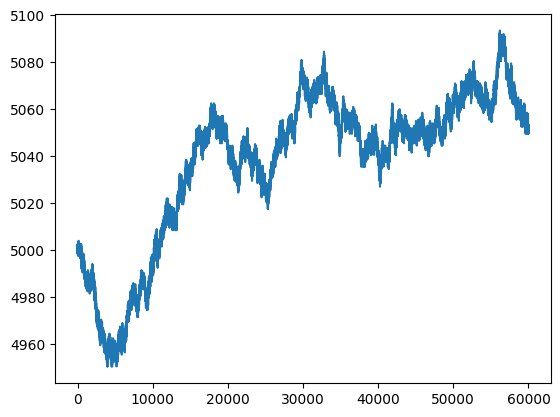

In [50]:
# plot mid price
plt.plot(raw[products[1]]['mid_price'])
plt.show()

# Linear regression

In [54]:
# Prepare the data
data_series = raw[products[1]]['mid_price']
raw[products[1]] = raw[products[1]].fillna(0)

weighted_data_series = (
    (raw[products[1]]['ask_price_1'] * raw[products[1]]['ask_volume_1'] +
     raw[products[1]]['bid_price_1'] * raw[products[1]]['bid_volume_1'] +
     raw[products[1]]['ask_price_2'] * raw[products[1]]['ask_volume_2'] +
     raw[products[1]]['bid_price_2'] * raw[products[1]]['bid_volume_2'] +
     raw[products[1]]['ask_price_3'] * raw[products[1]]['ask_volume_3'] +
     raw[products[1]]['bid_price_3'] * raw[products[1]]['bid_volume_3']) /
    (raw[products[1]]['ask_volume_1'] + raw[products[1]]['bid_volume_1'] +
     raw[products[1]]['ask_volume_2'] + raw[products[1]]['bid_volume_2'] +
     raw[products[1]]['ask_volume_3'] + raw[products[1]]['bid_volume_3'])
)

total_volume_bid = (
    raw[products[1]]['bid_volume_1'] +
    raw[products[1]]['bid_volume_2'] +
    raw[products[1]]['bid_volume_3']
)
total_volume_ask = (
    raw[products[1]]['ask_volume_1'] +
    raw[products[1]]['ask_volume_2'] +
    raw[products[1]]['ask_volume_3']
)

bb_price = (
    raw[products[1]]['bid_price_1'] * raw[products[1]]['bid_volume_1'] +
    raw[products[1]]['bid_price_2'] * raw[products[1]]['bid_volume_2'] +
    raw[products[1]]['bid_price_3'] * raw[products[1]]['bid_volume_3']
) / total_volume_bid

ba_price = (
    raw[products[1]]['ask_price_1'] * raw[products[1]]['ask_volume_1'] +
    raw[products[1]]['ask_price_2'] * raw[products[1]]['ask_volume_2'] +
    raw[products[1]]['ask_price_3'] * raw[products[1]]['ask_volume_3']
) / total_volume_ask

micro_price_df = (bb_price * total_volume_ask + ba_price * total_volume_bid) / (total_volume_bid + total_volume_ask)

In [89]:
mid_price = [int(price) for price in data_series]
weighted_pr = [int(weighted_data_s) for weighted_data_s in weighted_data_series]
micro_price = [int(x) for x in micro_price_df]
    
# SR is the series that we are trying to predict
SR = micro_price
SR_diff = np.diff(SR)

X = np.array([SR[i - 2:i] for i in range(10, len(SR))])
y = np.array([SR[i] for i in range(10, len(SR))])

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# Evaluate the model
train_score = model.score(X_train, y_train)
val_score = model.score(X_val, y_val)
test_score = model.score(X_test, y_test)

print("Training R^2 score:", train_score)
print("Validation R^2 score:", val_score)
print("Test R^2 score:", test_score)
print("Coefficients:", list(reversed(model.coef_)))
print("Intercept:", model.intercept_)
print("--------------------")

#compute mse
train_mse = mean_squared_error(y_train, train_predictions)
val_mse = mean_squared_error(y_val, val_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Training MSE:", train_mse)
print("Validation MSE:", val_mse)
print("Test MSE:", test_mse)

Training R^2 score: 0.9995029237402894
Validation R^2 score: 0.9994962007728617
Test R^2 score: 0.9995128985847284
Coefficients: [0.6490683280561522, 0.35073728421463835]
Intercept: 0.9858108634962264
--------------------
Training MSE: 0.5168948567824049
Validation MSE: 0.5268953350763376
Test MSE: 0.510876765590968


# ARIMA

[0.040756093101644526]
[-0.4555341046014984]
Intercept: 0.0016670624840474713


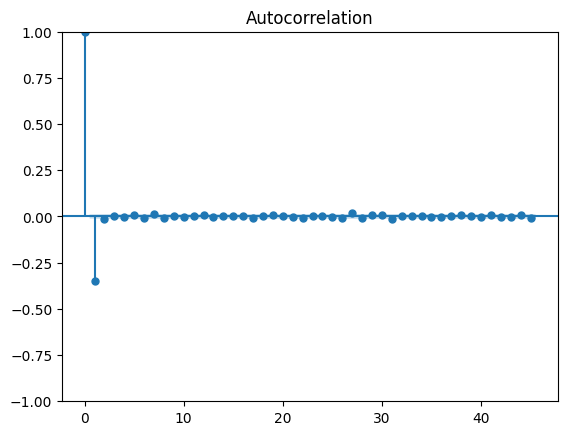

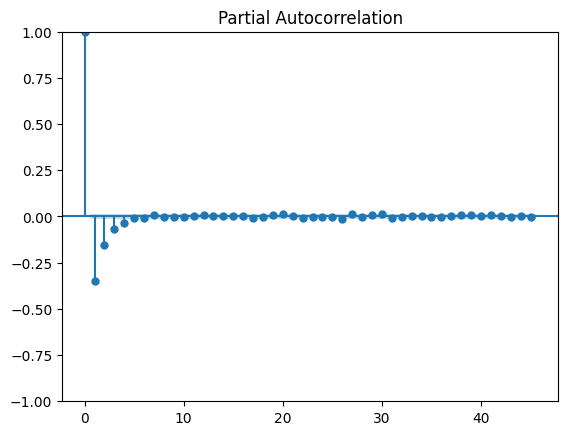

In [87]:
plot_acf(SR_diff)
plot_pacf(SR_diff)
model = ARIMA(SR_diff, order=(1, 0, 1)) 
results = model.fit()

print(list(results.arparams))
print(list(results.maparams))

# check accuracy
# predictions = results.predict(start=0, end=len(SR_diff) - 1)
# mse = mean_squared_error(SR, predictions)

# print("MSE:", mse)
print("Intercept:", results.params[0])

In [67]:
my_predictions = []
stanford_predictions = []

forecast_starfruit = Forecast(
        ar_coeffs=[0.5829995649961013, 0.22879986714195621, 0.1130056706312321, 0.0433244761665873, 0.03167469673244338],
        ma_coeffs=[],
        drift=0.9920684876224186,
        forecast_return=False
    )

forecast_stanford = Forecast(
        ar_coeffs=[0.8090892, 0.16316049, 0.0455032, -0.01869561],
        ma_coeffs=[],
        drift=4.481696494462085,
        forecast_return=False
    )

for i in range(0, 10):
    forecast_starfruit.update(micro_price[i])
    forecast_stanford.update(micro_price[i])
    
for i in range(10, len(SR)):
    forecast_starfruit.update(micro_price[i])    
    forecast_stanford.update(micro_price[i])
    
    my_predictions.append(forecast_starfruit.forecast(micro_price[i]))
    stanford_predictions.append(forecast_stanford.forecast(micro_price[i]))
    
# Plot my predictions
plt.plot(my_predictions, label='My predictions')
plt.plot(stanford_predictions, label='Stanford predictions')
plt.plot(micro_price[11:], label='True values')
plt.legend()
plt.show()

ValueError: shapes (4,) and (5,) not aligned: 4 (dim 0) != 5 (dim 0)